# UNet Model Implementation

In this notebook we implemented the UNet model to segment the given images into 25 different classes. The project pipeline is as follows:
* Image Processing
    * Convert the images into tensors to be ready to be fed into the networks
    * One hot encode the masks to make the labels readable
* Construct UNet Model
* Model Training
* Predict the masks on test images

We start by importing the relevant libraries.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model
import random


import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm as tq

import math
import torch
from torch.optim.optimizer import Optimizer, required

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, transforms
sns.set(style='white', context='notebook', palette='deep')

## 1 Image Processing

First of all we need to get the train data, which includes the original remote sensing images and their corresponding masks. The masks contain label information classifying each pixel into 25 different classes.

In [42]:
# Define the file path of the train images and masks.
img_folder = 'train_images'
mask_folder = 'train_masks'

### a. Check if we have corresponding masks for all images or not

In [44]:
# Create a list containing the file names of all train images.
image_ID = []
for x in os.listdir(img_folder):
    y = x.replace('.jpg','')
    image_ID.append(y)

In [45]:
# Create a list containing the file names of all train masks.
mask_ID = []
for x in os.listdir(mask_folder):
    y = x.replace('.png','')
    mask_ID.append(y)

Print the difference between the two file name list: if equals to 0, means that all images have their corresponding masks and the data is loaded successfully.

In [46]:
# Print the size of the train data set: 261 images in total
print(len(image_ID))
print(len(mask_ID))
print(len(set(image_ID).difference(set(mask_ID))))

261
261
0


### b. Read images into numpy array format
Store the train images as numpy array format in list X and train masks in list y.

In [50]:
# Preparing the data
X = []
y = []
h = 512
w = 512
for i,img_id in enumerate(image_ID):
    im_file   =  img_id+".jpg"
    im_path = os.path.join(img_folder,im_file)
    img = Image.open(im_path) # read image in PIL
    img = img.resize((w,h)) # first component is width and then height
    img_array = np.array(img)
    img_array = img_array/255.0  # Why??
    
    mask_file =  img_id+".png"
    mask_path = os.path.join(mask_folder,mask_file)
    mask = Image.open(mask_path)
    mask = mask.resize((w,h))
    mask_array = np.array(mask)
    
    X.append(img_array)
    y.append(mask_array)
    
    
    
X = np.array(X)
y = np.array(y)

In [51]:
print(X.shape)
print(y.shape)

(261, 512, 512, 3)
(261, 512, 512)


### c. Convert the numpy arrays into tensors

In [54]:
X=torch.from_numpy(X)
y=torch.from_numpy(y)

X = X.float()
y = y.to(torch.int64)

print(X.dtype,y.dtype)

torch.float32 torch.int64


In [55]:
print(X.size())
print(y.size())

torch.Size([261, 512, 512, 3])
torch.Size([261, 512, 512])


### d. One hot encode the masks into to read different labels

In [56]:
from torch.nn.functional import one_hot
y = one_hot(y)

In [57]:
print(X.size())
print(y.size())

torch.Size([261, 512, 512, 3])
torch.Size([261, 512, 512, 27])


In [58]:
Xt = torch.transpose(X, 1, 3)
yt = torch.transpose(y, 1, 3)
Xt.size()

torch.Size([261, 3, 512, 512])

In [59]:
yt.size()

torch.Size([261, 27, 512, 512])

### e. Train/validation data split
### f. Use the Dataloader package of torch to get the data ready for feeding into the torch model

In [65]:
full_dataset = torch.utils.data.TensorDataset(Xt, yt)

# Splitting into Train and Val
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Creating data_loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=False)

it, lt = next(iter(train_loader))
print(it.shape,lt.shape)

iv, lv = next(iter(val_loader))
print(iv.shape,lv.shape)

torch.Size([5, 3, 512, 512]) torch.Size([5, 27, 512, 512])
torch.Size([5, 3, 512, 512]) torch.Size([5, 27, 512, 512])


In [66]:
it, lt = next(iter(train_loader))
print(it.dtype,lt.dtype)

iv, lv = next(iter(val_loader))
print(iv.dtype,lv.dtype)

torch.float32 torch.int64
torch.float32 torch.int64


## 2. Construct the UNET model architecture

U-Net is an architecture for semantic segmentation. 
It consists of a contracting path and an expansive path. 
The contracting path follows the typical architecture of a convolutional network. 
It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), 
each followed by a rectified linear unit (ReLU)
and a 2x2 max pooling operation with stride 2 for downsampling. 
At each downsampling step we double the number of feature channels. 
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) 
that halves the number of feature channels, a concatenation 
with the correspondingly cropped feature map from the contracting path,
and two 3x3 convolutions, each followed by a ReLU. 
The cropping is necessary due to the loss of border pixels in every convolution.
At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. 
In total the network has 23 convolutional layers

<!-- # U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers

# U-net was originally invented and first used for biomedical image segmentation. Its architecture can be broadly thought of as an encoder network followed by a decoder network. Unlike classification where the end result of the the deep network is the only important thing, semantic segmentation not only requires discrimination at pixel level but also a mechanism to project the discriminative features learnt at different stages of the encoder onto the pixel space.

# 1 .The encoder is the first half in the architecture diagram. It usually is a pre-trained classification network like VGG/ResNet where you apply convolution blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.

# 2.The decoder is the second half of the architecture. The goal is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. The decoder consists of upsampling and concatenation followed by regular convolution operations. -->

In [67]:
# UNET model`

class double_conv(nn.Module):
    """(Conv2d => BatchNorm2d => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  # Convolution layer
            nn.BatchNorm2d(out_ch),  # Normalization layer
            nn.ReLU(inplace=True),  # Activation function
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Input
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

# Down sample
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x

# Up sample
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Output
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

# Structure of UNet
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

## 3. Model Training

### a. Define device being used and put the model on device

In [48]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  

In [70]:
model = UNet(3, 27)

In [71]:
model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

Summary of model:

In [72]:
from torchsummary import summary
summary(model,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
       double_conv-7         [-1, 64, 512, 512]               0
            inconv-8         [-1, 64, 512, 512]               0
         MaxPool2d-9         [-1, 64, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14        [-1, 128, 2

### b. Define dice score for evaluting the performance of the model

In [73]:
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())


def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice


### c. Customise an optimiser best suited for this problem (source: Kaggle Notebook)

In [74]:
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

### d. Define the loss functions

In [75]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
       activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp
    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)


In [76]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

# Model training

In [2]:
# Train on GPU if CUDA is available
train_on_gpu = torch.cuda.is_available()

NameError: name 'torch' is not defined

In [ ]:
n_epochs = 50         # Number of epochs to train the model
train_loss_list = []  # Store the train loss
valid_loss_list = []  # Store the validation loss
dice_score_list = []  # Store the dice scores
lr_rate_list = []     # Store the learning rate being used
valid_loss_min = np.Inf # For tracking change in validation loss


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        target = target.to(torch.float)
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(val_loader, postfix={"val_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            target = target.to(torch.float)
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_FDL_unet_1.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

Plot the learning rate during training

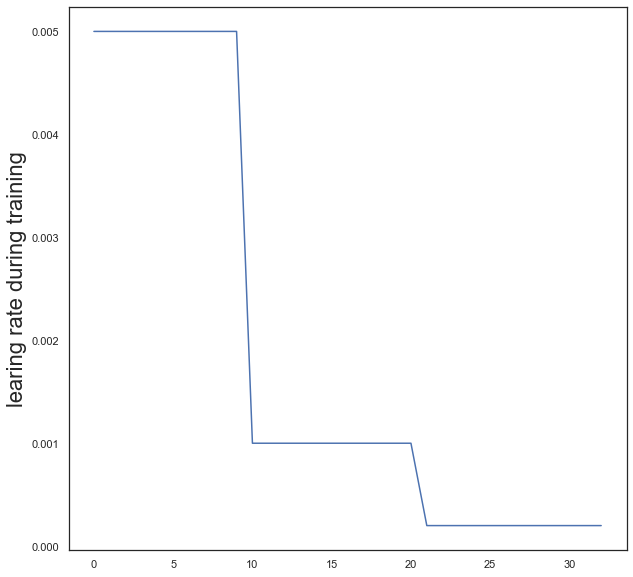

In [83]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

Plot the training loss and validation loss during training

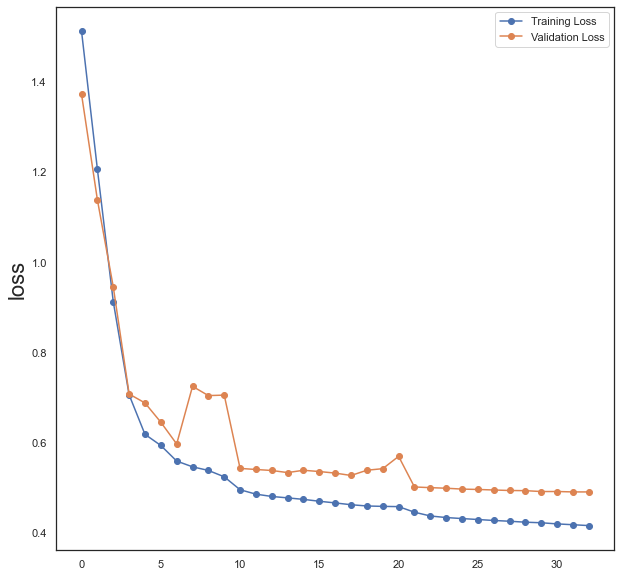

In [84]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

Plot the dice scores

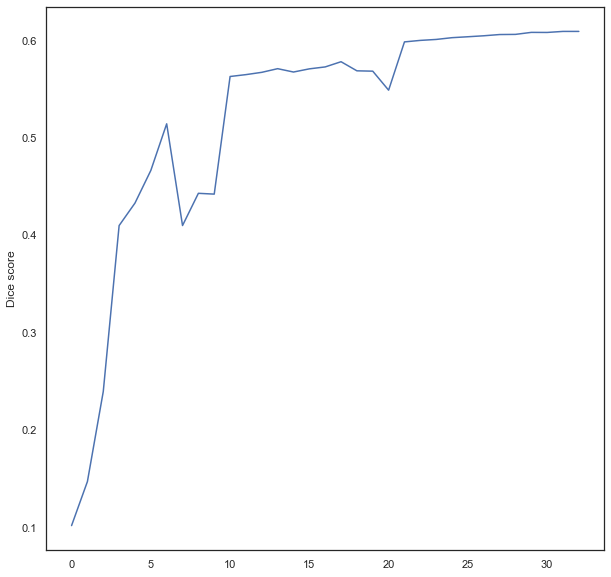

In [85]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

# Predict on test images

## a. Load the data and the model

Transform the test images in the same way as we transformed the train images.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

class TestDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.name = os.listdir(os.path.join(path, 'test_images'))

    def __len__(self):
        return len(self.name)

    def __getitem__(self, index):
        img_name = self.name[index]
        img_path = os.path.join(self.path, 'test_images',img_name)
        assert os.path.isfile(img_path)
        img = Image.open(img_path)
        img = img.resize((512,512))
        img = transform(img)
        
        return img

In [ ]:
test_dataset = TestDataset('')
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)
it = next(iter(test_loader))
print(it.shape,it.dtype)

Call the UNet model we constructed

Import the best model we trained onto our device.

In [ ]:
PATH = 'model_FDL_unet_30.pt'
device = torch.device('cpu')
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval();

## b. Predict the test mask

In [ ]:
test_mask=[]
for data in tq(test_loader):
    output = model(data).cpu().detach().numpy()
    print(output.shape)
    for b in range(output.shape[0]):
                   test_mask.append(output[b])

In [ ]:
mask = []
for m in test_mask:
    m1 = np.transpose(m,(1,2,0))
    mask.append(np.argmax(m1,axis=2))

In [ ]:
tarr = []
for x in os.listdir('test_images'):
    imp = os.path.join('test_images',x)
    img = Image.open(imp)
    i = np.array(img)
    tarr.append(i)

## c. Visualize to check how good are our test masks

In [ ]:
for i in range(len(tarr)):
    plt.subplot(1,2,1)
    plt.imshow(tarr[i])
    plt.subplot(1,2,2)
    plt.imshow(mask[i])
    plt.show()
    if i>=3:
        break;

## d. Save the test mask images locally

In [ ]:
path = r"C:\Users\rkroc\Desktop\FDL_kaggle\test_masks"
file_name = list(os.listdir('test_images'))
for i in range(len(mask)):
    mask_name = file_name[i]
    mask_name = mask_name.replace('jpg','png')
    file_path = os.path.join(path,mask_name)
    img = Image.fromarray(mask[i].astype('uint8'))
    img.save(file_path)
    print(i)

## e. Encode the masks images to prepare for the Kaggle submission 

In [ ]:
import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = 'test_masks/'
    N = len(list(os.listdir(dir)))
    with open('submission_file_unet.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir+i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()